# Lab 4. Случайный лес, решающие деревья, ансамбли

Исходные данные: датасет Mushroom
Доступ: https://archive.ics.uci.edu/dataset/73/mushroom

In [74]:
import pandas as pd 
import numpy as np
import enum
import time
import typing as tp
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [36]:
column_names = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 
                'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 
                'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
                'stalk-surface-below-ring', 'stalk-color-above-ring', 
                'stalk-color-below-ring', 'veil-type', 'veil-color', 
                'ring-number', 'ring-type', 'spore-print-color', 
                'population', 'habitat']
df = pd.read_csv("agaricus-lepiota.data", header=None, names=column_names)

In [37]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


## Задание 1: Решающее дерево

Реализуйте алгоритм построения решающего дерева классификации:
- Выберите и обоснуйте критерий разбиения;
- Критерий остановки разбиения вершины на поддеревья;
- Класс должен иметь стандартный интерфейс: fit, predict.

Обучите дерево на датасете.

Оцените качество классификации на тестовой выборке. Объясните выбор метрик качества.

Обратите внимание, что присутствует признак с пропусками. Модель должна каким-то образом это обрабатывать и не ломаться.

*Задание со звёздочкой: расчёт важности признаков для одного дерева.

In [24]:
class NodeType(enum.Enum):
    REGULAR = 1
    TERMINAL = 2


def gini(y: np.ndarray) -> float:
    """
    Computes Gini index for given set of labels
    :param y: labels
    :return: Gini impurity
    """
    if len(y) == 0:
        return 0.0
    _, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    return 1 - np.sum(probs ** 2)


def weighted_impurity(y_left: np.ndarray, y_right: np.ndarray) -> \
        tp.Tuple[float, float, float]:
    """
    Computes weighted impurity by averaging children impurities
    """
    len_y_left: int = len(y_left)
    len_y_right: int = len(y_right)
    len_y: int = len_y_left + len_y_right
    
    if len_y == 0:
        return 0.0, 0.0, 0.0

    left_impurity: float = gini(y_left)
    right_impurity: float = gini(y_right)
    
    averaged_impurity = (len_y_left * left_impurity + len_y_right * right_impurity) / len_y
    return averaged_impurity, left_impurity, right_impurity


def create_split(feature_values: np.ndarray, threshold: float) -> tp.Tuple[np.ndarray, np.ndarray]:
    """
    splits given 1-d array according to relation to threshold into two subarrays
    Convention: Left <= Threshold, Right > Threshold
    """
    left_idx = np.where(feature_values <= threshold)[0]
    right_idx = np.where(feature_values > threshold)[0]
    return left_idx, right_idx


class MyDecisionTreeNode:
    """
    Auxiliary class serving as representation of a decision tree node
    """

    def __init__(
            self,
            meta: 'MyDecisionTreeClassifier',
            depth,
            node_type: NodeType = NodeType.REGULAR,
            predicted_class: tp.Optional[tp.Union[int, str]] = None,
            left_subtree: tp.Optional['MyDecisionTreeNode'] = None,
            right_subtree: tp.Optional['MyDecisionTreeNode'] = None,
            feature_id: int = None,
            threshold: float = None,
            impurity: float = np.inf
    ):
        self._node_type = node_type
        self._meta = meta
        self._depth = depth
        self._predicted_class = predicted_class
        self._class_proba = None
        self._left_subtree = left_subtree
        self._right_subtree = right_subtree
        self._feature_id = feature_id
        self._threshold = threshold
        self._impurity = impurity

    def _best_split(self, X: np.ndarray, y: np.ndarray):
        """
        finds best split
        :param X: Data, passed to node
        :param y: labels
        :return: best feature, best threshold, left child impurity, right child impurity
        """
        lowest_impurity = np.inf
        best_feature_id = None
        best_threshold = None
        lowest_left_child_impurity = None
        lowest_right_child_impurity = None
        
        n_features = X.shape[1]
        features = self._meta.rng.permutation(n_features)
        
        for feature in features:
            current_feature_values = X[:, feature]
            unique_values = np.unique(current_feature_values)
            
            if len(unique_values) < 2:
                continue
            for threshold in unique_values[:-1]: 
                left_idx, right_idx = create_split(current_feature_values, threshold)
                
                if len(left_idx) == 0 or len(right_idx) == 0:
                    continue
                
                y_left = y[left_idx]
                y_right = y[right_idx]
                
                current_weighted_imp, left_imp, right_imp = weighted_impurity(y_left, y_right)
                
                if current_weighted_imp < lowest_impurity:
                    lowest_impurity = current_weighted_imp
                    best_feature_id = feature
                    best_threshold = threshold
                    lowest_left_child_impurity = left_imp
                    lowest_right_child_impurity = right_imp

        return best_feature_id, best_threshold, lowest_left_child_impurity, lowest_right_child_impurity

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        recursively fits a node
        """
        counts = Counter(y)
        n_samples = len(y)
        self._class_proba = np.zeros(self._meta._n_classes)
        for cls, count in counts.items():
            if 0 <= int(cls) < self._meta._n_classes:
                self._class_proba[int(cls)] = count / n_samples
        is_pure = (len(np.unique(y)) == 1)
        max_depth_reached = (self._depth >= self._meta.max_depth)
        not_enough_samples = (n_samples < self._meta.min_samples_split)

        if is_pure or max_depth_reached or not_enough_samples:
            self._make_terminal(y)
            return self
        self._feature_id, self._threshold, left_imp, right_imp = self._best_split(X, y)
        if self._feature_id is None:
            self._make_terminal(y)
            return self
        left_idx, right_idx = create_split(X[:, self._feature_id], self._threshold)
        self._left_subtree = MyDecisionTreeNode(
            meta=self._meta,
            depth=self._depth + 1,
            impurity=left_imp
        ).fit(X[left_idx], y[left_idx])
        self._right_subtree = MyDecisionTreeNode(
            meta=self._meta,
            depth=self._depth + 1,
            impurity=right_imp
        ).fit(X[right_idx], y[right_idx])
        return self

    def _make_terminal(self, y: np.ndarray):
        self._node_type = NodeType.TERMINAL
        vals, counts = np.unique(y, return_counts=True)
        self._predicted_class = vals[np.argmax(counts)]
    
    def predict(self, x: np.ndarray):
        """
        Predicts class for a single object
        """
        if self._node_type is NodeType.TERMINAL:
            return self._predicted_class
        
        if x[self._feature_id] <= self._threshold:
            return self._left_subtree.predict(x)
        else:
            return self._right_subtree.predict(x)

    def predict_proba(self, x: np.ndarray):
        """
        Predicts probability for a single object
        """
        if self._node_type is NodeType.TERMINAL:
            return self._class_proba
        
        if x[self._feature_id] <= self._threshold:
            return self._left_subtree.predict_proba(x)
        else:
            return self._right_subtree.predict_proba(x)

In [25]:
class MyDecisionTreeClassifier:
    """
    Class analogous to sklearn implementation of decision tree classifier with Gini impurity criterion,
    named in a manner avoiding collisions.
    """

    def __init__(
            self,
            max_depth: tp.Optional[int] = None,
            min_samples_split: tp.Optional[int] = 2,
            seed: int = 0
    ):
        """
        :param max_depth: maximal depth of tree, prevents overfitting
        :param min_samples_split: minimal amount of samples for node to be a splitter node
        :param seed: seed for RNG, enables reproducibility
        """
        self.root = MyDecisionTreeNode(self, 1)
        self._is_trained = False
        self.max_depth = max_depth or np.inf
        self.min_samples_split = min_samples_split or 2
        self.rng = np.random.default_rng(seed)
        self._n_classes = 0

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Starts recursive process of node criterion fitting from the root.
        :param X: Data
        :param y: labels
        :return: fitted self
        """
        unique_y = np.unique(y)
        self._n_classes = int(np.max(unique_y)) + 1 if len(unique_y) > 0 else 0
        
        self.root.fit(X, y)
        self._is_trained = True
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predicts class for a sequence of objects.
        :param X: Data
        :return: classes assigned to each object
        """
        if not self._is_trained:
            raise RuntimeError('predict call on untrained model')
        return np.apply_along_axis(self.root.predict, axis=1, arr=X)

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Predicts class probabilities for a sequence of objects.
        :param X: Data
        :return: probabilities of all classes for each object
        """
        if not self._is_trained:
            raise RuntimeError('predict call on untrained model')
        
        predictions = [self.root.predict_proba(x) for x in X]
        return np.array(predictions)

In [26]:
label_encoders = {}
for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
label_encoders

{'class': LabelEncoder(),
 'cap-shape': LabelEncoder(),
 'cap-surface': LabelEncoder(),
 'cap-color': LabelEncoder(),
 'bruises': LabelEncoder(),
 'odor': LabelEncoder(),
 'gill-attachment': LabelEncoder(),
 'gill-spacing': LabelEncoder(),
 'gill-size': LabelEncoder(),
 'gill-color': LabelEncoder(),
 'stalk-shape': LabelEncoder(),
 'stalk-root': LabelEncoder(),
 'stalk-surface-above-ring': LabelEncoder(),
 'stalk-surface-below-ring': LabelEncoder(),
 'stalk-color-above-ring': LabelEncoder(),
 'stalk-color-below-ring': LabelEncoder(),
 'veil-type': LabelEncoder(),
 'veil-color': LabelEncoder(),
 'ring-number': LabelEncoder(),
 'ring-type': LabelEncoder(),
 'spore-print-color': LabelEncoder(),
 'population': LabelEncoder(),
 'habitat': LabelEncoder()}

In [27]:
y = df['class'].values
X = df.drop('class', axis=1).values
feature_names = df.drop('class', axis=1).columns

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [29]:
def fit_with_importance(self, X, y):
    self.feature_importances_ = np.zeros(X.shape[1])
    self._n_classes = len(np.unique(y))
    self.root.fit(X, y)
    self._is_trained = True
    if np.sum(self.feature_importances_) > 0:
        self.feature_importances_ /= np.sum(self.feature_importances_)
    return self

In [30]:
def node_fit_wrapper(node_self, X, y):
    counts = np.bincount(y) if y.dtype == int else np.unique(y, return_counts=True)[1]
    n_samples = len(y)
    node_self._class_proba = np.zeros(node_self._meta._n_classes)
    for cls_idx in range(len(counts)): 
        if cls_idx < len(node_self._class_proba):
            node_self._class_proba[cls_idx] = counts[cls_idx] / n_samples
    
    node_self._predicted_class = np.argmax(counts)

    if (len(np.unique(y)) == 1) or \
       (node_self._depth >= node_self._meta.max_depth) or \
       (n_samples < node_self._meta.min_samples_split):
        node_self._node_type = NodeType.TERMINAL
        return node_self
    current_impurity = gini(y)
    node_self._feature_id, node_self._threshold, left_imp, right_imp = node_self._best_split(X, y)
    
    if node_self._feature_id is None:
        node_self._node_type = NodeType.TERMINAL
        return node_self
    left_idx, right_idx = create_split(X[:, node_self._feature_id], node_self._threshold)
    n_left, n_right = len(left_idx), len(right_idx)
    weighted_child_impurity = (n_left * left_imp + n_right * right_imp) / n_samples
    
    impurity_decrease = (current_impurity - weighted_child_impurity) * n_samples
    
    node_self._meta.feature_importances_[node_self._feature_id] += impurity_decrease

    node_self._left_subtree = MyDecisionTreeNode(
        meta=node_self._meta, depth=node_self._depth + 1, impurity=left_imp
    ).fit(X[left_idx], y[left_idx])
    
    node_self._right_subtree = MyDecisionTreeNode(
        meta=node_self._meta, depth=node_self._depth + 1, impurity=right_imp
    ).fit(X[right_idx], y[right_idx])
    
    return node_self

In [31]:
MyDecisionTreeClassifier.fit = fit_with_importance
MyDecisionTreeNode.fit = node_fit_wrapper

In [32]:
print("Начинаем обучение дерева...")
model = MyDecisionTreeClassifier(max_depth=10, min_samples_split=5)
model.fit(X_train, y_train)
print("Обучение завершено.")

Начинаем обучение дерева...
Обучение завершено.


In [33]:
y_pred = model.predict(X_test)
y_pred

array([0, 1, 0, ..., 1, 1, 0])

In [40]:
print(f"Mapping классов: {dict(zip(label_encoders['class'].classes_, label_encoders['class'].transform(label_encoders['class'].classes_)))}")

Mapping классов: {'e': 0, 'p': 1}


In [41]:
print("\n=== Отчет о классификации ===")
print(classification_report(y_test, y_pred, target_names=label_encoders['class'].classes_))


=== Отчет о классификации ===
              precision    recall  f1-score   support

           e       1.00      1.00      1.00      1052
           p       1.00      1.00      1.00       979

    accuracy                           1.00      2031
   macro avg       1.00      1.00      1.00      2031
weighted avg       1.00      1.00      1.00      2031



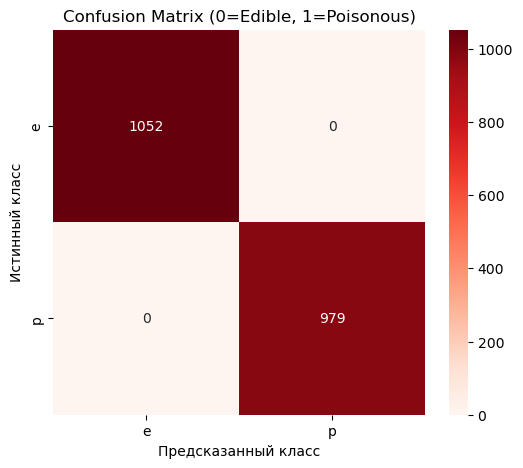

In [42]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=label_encoders['class'].classes_, 
            yticklabels=label_encoders['class'].classes_)
plt.title('Confusion Matrix (0=Edible, 1=Poisonous)')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

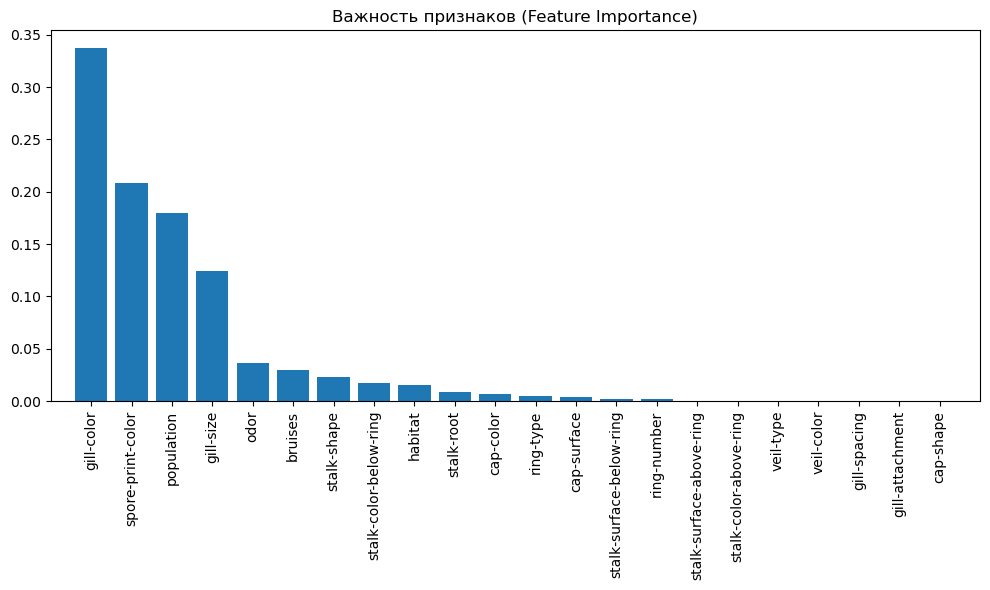

Топ-3 самых важных признака:
1. gill-color (Weight: 0.3373)
2. spore-print-color (Weight: 0.2083)
3. population (Weight: 0.1800)


In [44]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Важность признаков (Feature Importance)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

print("Топ-3 самых важных признака:")
for i in range(3):
    print(f"{i+1}. {feature_names[indices[i]]} (Weight: {importances[indices[i]]:.4f})")

## Задание 2: Случайный лес

На основе реализованного дерева постройте случайный лес:
- Для каждого дерева выбирайте случайно признаки и объекты для обучения (подробнее об этом можно прочитать по ссылке);
- Реализуйте механизм голосования;
- Добавьте метод predict_proba.

Проведите обучение и тестирование случайного леса.

Сравните качество классификации с одиночным деревом.

Постройте график зависимости точности от количества деревьев в ансамбле.

Визуализируйте уверенность модели в ответах (отдельно на неверно классифицированных объектах). Используйте predict_proba.

Задание на поисследовать мир: постройте случайный лес из решающих пней, сравните с лесом из глубоких деревьев.


In [49]:
class MyRandomForestClassifier:
    """
    Реализация Random Forest с бэггингом (bootstrap) и методом случайных подпространств (random features).
    """
    big_number = 1 << 32

    def __init__(
            self,
            n_estimators: int,
            max_depth: tp.Optional[int] = None,
            min_samples_split: tp.Optional[int] = 2,
            max_features: tp.Union[str, int, float] = 'sqrt', # Новая опция
            seed: int = 0
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.seed = seed
        
        self._n_classes = 0
        self._is_trained = False
        self.rng = np.random.default_rng(seed)
        self.estimators = [] 

    def _bootstrap_sample(self, X: np.ndarray, y: np.ndarray):
        n_samples = X.shape[0]
        indices = self.rng.choice(n_samples, size=n_samples, replace=True)
        return X[indices], y[indices]

    def _get_feature_indices(self, n_total_features):
        """Определяет количество и индексы случайных признаков для дерева"""
        if isinstance(self.max_features, int):
            n_select = min(self.max_features, n_total_features)
        elif isinstance(self.max_features, float):
            n_select = int(self.max_features * n_total_features)
        elif self.max_features == 'sqrt':
            n_select = int(np.sqrt(n_total_features))
        elif self.max_features == 'log2':
            n_select = int(np.log2(n_total_features))
        else:
            n_select = n_total_features
        return self.rng.choice(n_total_features, size=max(1, n_select), replace=False)

    def fit(self, X: np.ndarray, y: np.ndarray):
        self._n_classes = len(np.unique(y))
        n_features = X.shape[1]
        
        self.estimators = []
        tree_seeds = self.rng.choice(max(self.big_number, self.n_estimators), 
                                     size=self.n_estimators, replace=False)

        for i in range(self.n_estimators):
            X_boot, y_boot = self._bootstrap_sample(X, y)
            feat_indices = self._get_feature_indices(n_features)
            X_sub = X_boot[:, feat_indices]
            tree = MyDecisionTreeClassifier(
                max_depth=self.max_depth, 
                min_samples_split=self.min_samples_split, 
                seed=tree_seeds[i]
            )
            tree.fit(X_sub, y_boot)
            self.estimators.append((tree, feat_indices))
            
        self._is_trained = True
        return self

    def predict_proba(self, X: np.ndarray):
        if not self._is_trained:
            raise RuntimeError("Model not trained")
        probas_sum = np.zeros((X.shape[0], self._n_classes))
        
        for tree, feat_indices in self.estimators:
            probas_sum += tree.predict_proba(X[:, feat_indices])
        return probas_sum / self.n_estimators

    def predict(self, X):
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)

In [52]:
print("--- Обучение одиночного дерева ---")
tree_model = MyDecisionTreeClassifier(max_depth=10, seed=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
acc_tree = accuracy_score(y_test, y_pred_tree)
print(f"Точность (Accuracy) дерева: {acc_tree:.4f}")

print("\n--- Обучение случайного леса (30 деревьев) ---")
rf_model = MyRandomForestClassifier(n_estimators=30, max_depth=10, max_features='sqrt', seed=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Точность (Accuracy) леса: {acc_rf:.4f}")

print(f"\nПрирост точности: {(acc_rf - acc_tree)*100:.2f}%")

--- Обучение одиночного дерева ---
Точность (Accuracy) дерева: 1.0000

--- Обучение случайного леса (30 деревьев) ---
Точность (Accuracy) леса: 0.9985

Прирост точности: -0.15%



Построение графика зависимости от числа деревьев...


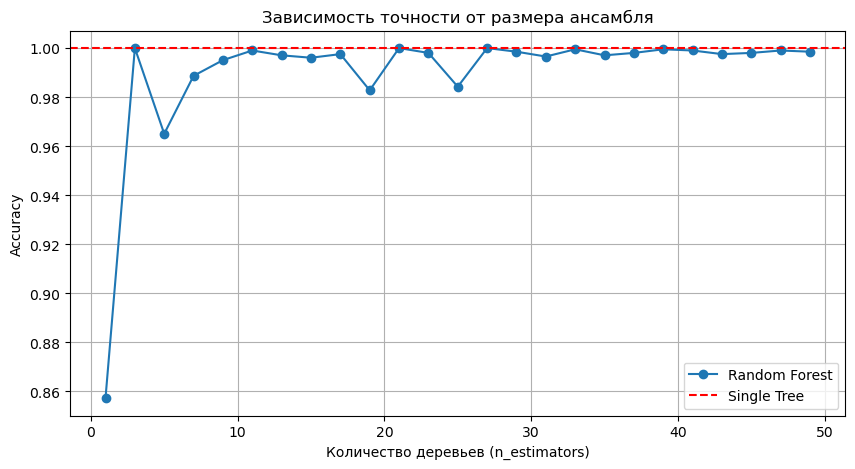

In [59]:
n_trees_list = range(1, 51, 2)
accuracies = []

print("\nПостроение графика зависимости от числа деревьев...")
for n in n_trees_list:
    rf = MyRandomForestClassifier(n_estimators=n, max_depth=10, max_features='sqrt', seed=42)
    rf.fit(X_train, y_train)
    acc = accuracy_score(y_test, rf.predict(X_test))
    accuracies.append(acc)

plt.figure(figsize=(10, 5))
plt.plot(n_trees_list, accuracies, marker='o', label='Random Forest')
plt.axhline(y=acc_tree, color='r', linestyle='--', label='Single Tree')
plt.xlabel("Количество деревьев (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Зависимость точности от размера ансамбля")
plt.legend()
plt.grid(True)
plt.show()

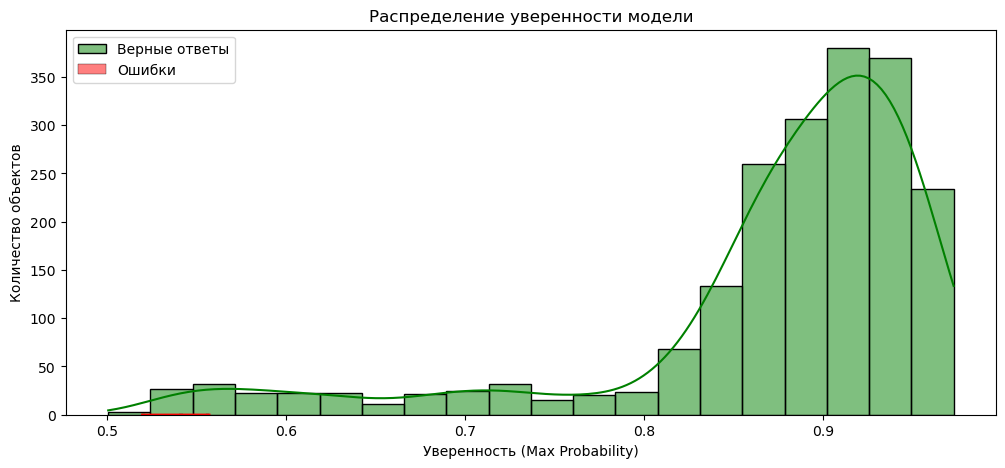

In [53]:
probas = rf_model.predict_proba(X_test)
confidence = np.max(probas, axis=1)
correct_mask = (y_pred_rf == y_test)

plt.figure(figsize=(12, 5))

sns.histplot(confidence[correct_mask], color='green', label='Верные ответы', kde=True, bins=20, alpha=0.5)

if np.sum(~correct_mask) > 0:
    sns.histplot(confidence[~correct_mask], color='red', label='Ошибки', kde=True, bins=20, alpha=0.5)
else:
    print("Ошибок на тесте нет! График ошибок пуст.")

plt.title("Распределение уверенности модели")
plt.xlabel("Уверенность (Max Probability)")
plt.ylabel("Количество объектов")
plt.legend()
plt.show()


--- Эксперимент: Пни vs Глубокие деревья ---
Accuracy (Forest of Stumps, depth=1): 0.5180
Accuracy (Deep Forest, depth=20):      0.9985


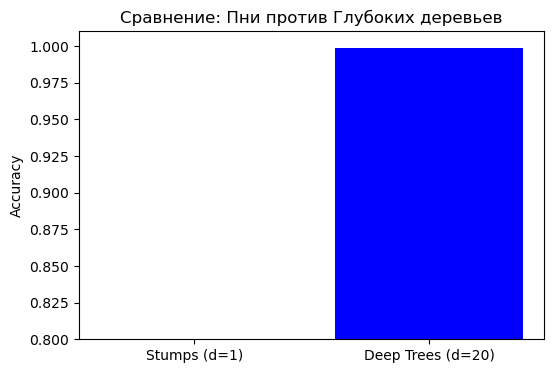

In [54]:
print("\n--- Эксперимент: Пни vs Глубокие деревья ---")

rf_stumps = MyRandomForestClassifier(n_estimators=50, max_depth=1, max_features='sqrt', seed=42)
rf_stumps.fit(X_train, y_train)
acc_stumps = accuracy_score(y_test, rf_stumps.predict(X_test))

rf_deep = MyRandomForestClassifier(n_estimators=50, max_depth=20, max_features='sqrt', seed=42)
rf_deep.fit(X_train, y_train)
acc_deep = accuracy_score(y_test, rf_deep.predict(X_test))

print(f"Accuracy (Forest of Stumps, depth=1): {acc_stumps:.4f}")
print(f"Accuracy (Deep Forest, depth=20):      {acc_deep:.4f}")

plt.figure(figsize=(6, 4))
plt.bar(['Stumps (d=1)', 'Deep Trees (d=20)'], [acc_stumps, acc_deep], color=['orange', 'blue'])
plt.ylim(0.8, 1.01)
plt.title("Сравнение: Пни против Глубоких деревьев")
plt.ylabel("Accuracy")
plt.show()

## Задание 3: AdaBoost
То же самое: реализовать, оценить качество, сравнить с другими моделями, построить график зависимости точности от количества деревьев, объяснить график.

In [66]:
class MyAdaBoostClassifier:
    def __init__(self, n_estimators: int = 50, learning_rate: float = 1.0, seed: int = 42):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.seed = seed
        self.estimators = []
        self.alphas = []
        self.rng = np.random.default_rng(seed)
        self._classes = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        n_samples = X.shape[0]
        self._classes = np.unique(y)
        n_classes = len(self._classes)
        sample_weights = np.full(n_samples, 1 / n_samples)
        
        self.estimators = []
        self.alphas = []

        for i in range(self.n_estimators):
            indices = self.rng.choice(n_samples, size=n_samples, replace=True, p=sample_weights)
            X_sample, y_sample = X[indices], y[indices]
            stump = MyDecisionTreeClassifier(max_depth=2, seed=self.seed + i)
            stump.fit(X_sample, y_sample)
            y_pred = stump.predict(X)
            incorrect = (y_pred != y)
            error = np.average(incorrect, weights=sample_weights)
            if error == 0:
                alpha = 5.0 
                self.estimators.append(stump)
                self.alphas.append(alpha)
                break
            if error >= 1.0 - (1.0 / n_classes): 
                 break
            epsilon = 1e-10
            alpha = self.learning_rate * 0.5 * np.log((1 - error + epsilon) / (error + epsilon))
            if n_classes > 2:
                alpha += np.log(n_classes - 1)
            sample_weights[incorrect] *= np.exp(alpha)
            weight_sum = np.sum(sample_weights)
            if weight_sum > 0:
                sample_weights /= weight_sum

            self.estimators.append(stump)
            self.alphas.append(alpha)

        self._is_trained = True
        return self

    def predict(self, X: np.ndarray):
        if not self.estimators:
            return np.zeros(X.shape[0], dtype=int)

        n_samples = X.shape[0]
        class_scores = np.zeros((n_samples, len(self._classes)))
        
        for stump, alpha in zip(self.estimators, self.alphas):
            preds = stump.predict(X)
            for c_idx, c_val in enumerate(self._classes):
                mask = (preds == c_val)
                class_scores[mask, c_idx] += alpha
        indices = np.argmax(class_scores, axis=1)
        return self._classes[indices]

In [67]:
print("\n--- Обучение AdaBoost (1 дерево) ---")
ada = MyAdaBoostClassifier(n_estimators=1, learning_rate=1.0, seed=42)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)
acc_ada_1 = accuracy_score(y_test, y_pred_ada)
print(f"Точность (Accuracy) AdaBoost: {acc_ada_1:.4f}")

print("\n--- Обучение AdaBoost (30 деревьев) ---")
ada = MyAdaBoostClassifier(n_estimators=30, learning_rate=1.0, seed=42)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)
acc_ada_30 = accuracy_score(y_test, y_pred_ada)
print(f"Точность (Accuracy) AdaBoost: {acc_ada_30:.4f}")

print(f"\nПрирост точности: {(acc_ada_30 - acc_ada_1)*100:.2f}%")


--- Обучение AdaBoost (1 дерево) ---
Точность (Accuracy) AdaBoost: 0.7957

--- Обучение AdaBoost (30 деревьев) ---
Точность (Accuracy) AdaBoost: 0.9847

Прирост точности: 18.91%


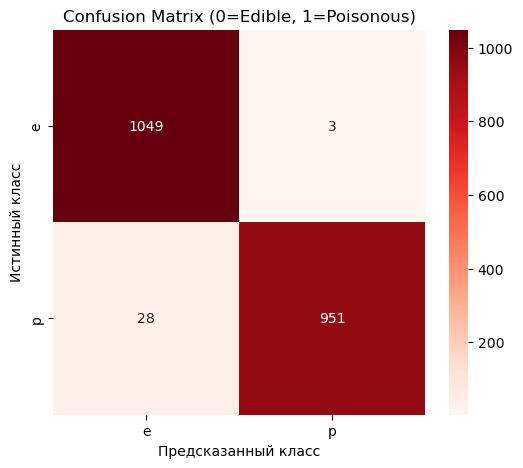

In [71]:
cm = confusion_matrix(y_test, y_pred_ada)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=label_encoders['class'].classes_, 
            yticklabels=label_encoders['class'].classes_)
plt.title('Confusion Matrix (0=Edible, 1=Poisonous)')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

In [69]:
tree = MyDecisionTreeClassifier(max_depth=10, seed=42)
tree.fit(X_train, y_train)
acc_tree = accuracy_score(y_test, tree.predict(X_test))

rf = MyRandomForestClassifier(n_estimators=30, max_depth=10, max_features='sqrt', seed=42)
rf.fit(X_train, y_train)
acc_rf = accuracy_score(y_test, rf.predict(X_test))

ada = MyAdaBoostClassifier(n_estimators=30, learning_rate=1.0, seed=42)
ada.fit(X_train, y_train)
acc_ada = accuracy_score(y_test, ada.predict(X_test))

print(f"Accuracy Single Tree: {acc_tree:.4f}")
print(f"Accuracy Random Forest: {acc_rf:.4f}")
print(f"Accuracy AdaBoost:      {acc_ada:.4f}")

Accuracy Single Tree: 1.0000
Accuracy Random Forest: 0.9985
Accuracy AdaBoost:      0.9847


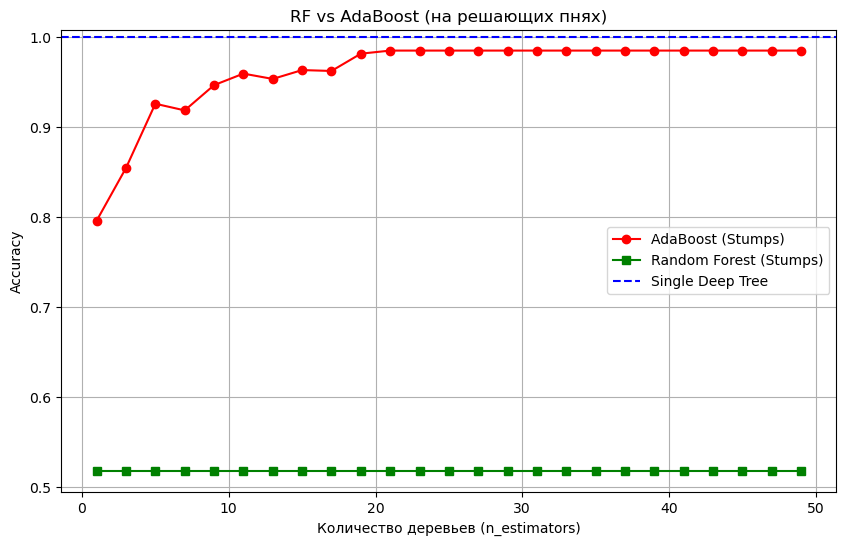

In [70]:
n_estimators_list = range(1, 51, 2)
ada_scores = []
rf_scores = []

for n in n_estimators_list:
    model_ada = MyAdaBoostClassifier(n_estimators=n, learning_rate=1.0, seed=42)
    model_ada.fit(X_train, y_train)
    ada_scores.append(accuracy_score(y_test, model_ada.predict(X_test)))

    model_rf = MyRandomForestClassifier(n_estimators=n, max_depth=1, max_features='sqrt', seed=42)
    model_rf.fit(X_train, y_train)
    rf_scores.append(accuracy_score(y_test, model_rf.predict(X_test)))

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, ada_scores, marker='o', label='AdaBoost (Stumps)', color='red')
plt.plot(n_estimators_list, rf_scores, marker='s', label='Random Forest (Stumps)', color='green')
plt.axhline(y=acc_tree, color='blue', linestyle='--', label='Single Deep Tree')

plt.xlabel('Количество деревьев (n_estimators)')
plt.ylabel('Accuracy')
plt.title('RF vs AdaBoost (на решающих пнях)')
plt.legend()
plt.grid(True)
plt.show()

## Задание 4: Сравнение с библиотечными реализациями

Используйте scikit-learn для обучения DecisionTreeClassifier, RandomForestClassifier и AdaBoostClassifier.

Сравните результаты с вашей реализацией:
- Точность;
- Скорость обучения;
- Интерпретируемость;
- Поддерживаемые фичи.


In [75]:
def benchmark_model(model, name, X_train, y_train, X_test, y_test):
    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()
    train_time = end_train - start_train
    start_pred = time.time()
    y_pred = model.predict(X_test)
    end_pred = time.time()
    pred_time = end_pred - start_pred
    acc = accuracy_score(y_test, y_pred)
    
    return {
        "Model": name,
        "Accuracy": acc,
        "Train Time (sec)": train_time,
        "Pred Time (sec)": pred_time
    }

In [76]:
results = []

dt_custom = MyDecisionTreeClassifier(max_depth=10, seed=42)
results.append(benchmark_model(dt_custom, "My Decision Tree", X_train, y_train, X_test, y_test))

# Sklearn
dt_sklearn = DecisionTreeClassifier(max_depth=10, random_state=42, criterion='gini')
results.append(benchmark_model(dt_sklearn, "Sklearn Decision Tree", X_train, y_train, X_test, y_test))

# --- 2. Random Forest ---
# Custom (30 деревьев)
rf_custom = MyRandomForestClassifier(n_estimators=30, max_depth=10, max_features='sqrt', seed=42)
results.append(benchmark_model(rf_custom, "My Random Forest", X_train, y_train, X_test, y_test))

# Sklearn (30 деревьев)
rf_sklearn = RandomForestClassifier(n_estimators=30, max_depth=10, max_features='sqrt', random_state=42)
results.append(benchmark_model(rf_sklearn, "Sklearn Random Forest", X_train, y_train, X_test, y_test))

# --- 3. AdaBoost ---
# Custom (30 пней)
ada_custom = MyAdaBoostClassifier(n_estimators=30, learning_rate=1.0, seed=42)
results.append(benchmark_model(ada_custom, "My AdaBoost", X_train, y_train, X_test, y_test))

# Sklearn (30 пней)
# По умолчанию Sklearn использует DecisionTreeClassifier(max_depth=1)
ada_sklearn = AdaBoostClassifier(n_estimators=30, learning_rate=1.0, random_state=42, algorithm='SAMME')
results.append(benchmark_model(ada_sklearn, "Sklearn AdaBoost", X_train, y_train, X_test, y_test))

# Вывод результатов
df_results = pd.DataFrame(results)
print(df_results.round(4))

                   Model  Accuracy  Train Time (sec)  Pred Time (sec)
0       My Decision Tree    1.0000            0.1408           0.0045
1  Sklearn Decision Tree    1.0000            0.0097           0.0004
2       My Random Forest    0.9985            0.6382           0.0886
3  Sklearn Random Forest    1.0000            0.0699           0.0050
4            My AdaBoost    0.9847            1.0386           0.0970
5       Sklearn AdaBoost    0.9911            0.0995           0.0062
